In [1]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import seaborn as sns
import pandas as pd
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import scipy
from tensorflow.keras.applications.resnet50 import preprocess_input


2023-11-01 08:06:02.390747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 08:06:02.390778: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 08:06:02.390795: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 08:06:02.396074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Loading 

In [2]:
# Setup paths to the training and test directories
training_dir = 'fruits_dataset/fruits-360_dataset/fruits-360/Training'
test_dir = 'fruits_dataset/fruits-360_dataset/fruits-360/Test'

# Using ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # using 10% of the training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from the directories and dataset split
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # set as training data
)

validation_generator = train_datagen.flow_from_directory(
    training_dir,  # same directory as training data
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # set as validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

Found 60955 images belonging to 131 classes.
Found 6737 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## Model Implementation 

### Baseline CNN Model

In [3]:
# Define the baseline CNN model
def build_baseline_model(input_shape, num_classes):
    model = Sequential([
        # Convolutional layer with 32 filters, kernel size of 3x3, and ReLU activation
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        # Second convolutional layer with 64 filters
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Third convolutional layer with 64 filters
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Flattening the 3D output to 1D
        Flatten(),
        
        # Fully connected layer with 64 units and ReLU activation
        Dense(64, activation='relu'),
        
        # Dropout for regularization
        Dropout(0.5),
        
        # Output layer with softmax activation
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [4]:
# Images are 100x100 pixels and there are 131 classes as in the Fruits-360 dataset
input_shape = (100, 100, 3)  # 3 channels for RGB
num_classes = 131  

# Build the model
baseline_model = build_baseline_model(input_shape, num_classes)

# Summary of the baseline model
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)        0

2023-11-01 08:06:18.744264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 08:06:18.748832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 08:06:18.748946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### ResNet with  pre-trained weights

In [27]:
# Using ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # using 10% of the training data for validation
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1./255)

# Load images from the directories and dataset split
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # set as training data
)

validation_generator = train_datagen.flow_from_directory(
    training_dir,  # same directory as training data
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # set as validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

Found 60955 images belonging to 131 classes.
Found 6737 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [34]:
# Load ResNet50 with pre-trained ImageNet weights
ResNet_base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(100, 100, 3)))

# Freeze the layers of the base model
for layer in ResNet_base_model.layers:
    layer.trainable = False

# Add custom top layers for our classification problem
x = ResNet_base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
head_model = Dense(num_classes, activation='softmax')(x)


# Create the full model
ResNet_model = Model(inputs=ResNet_base_model.input, outputs=head_model)

# Compile the model
ResNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
ResNet_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 106, 106, 3)          0         ['input_10[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 50, 50, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 50, 50, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

## Model Training

### Baseline CNN Model

In [5]:
# Set the number of epochs and batch size
epochs = 50 
batch_size = 32  # Matches the batch_size used in the generators

# Fit the model using the generators
baseline_history = baseline_model.fit(
    train_generator,
    steps_per_epoch= train_generator.samples // batch_size,  # Number of batches per epoch
    epochs=epochs,
    validation_data= validation_generator,
    validation_steps= validation_generator.samples // batch_size,  # Validation batches
    verbose=1
)

Epoch 1/50


2023-11-01 08:06:29.281209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-01 08:06:30.033899: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f17dc0159f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-01 08:06:30.033923: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-11-01 08:06:30.040244: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-01 08:06:30.130870: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1904/1904 [==============================] - 110s 57ms/step - loss: 3.3217 - accuracy: 0.1381 - val_loss: 1.6091 - val_accuracy: 0.5914
Epoch 2/50
1904/1904 [==============================] - 107s 56ms/step - loss: 2.3289 - accuracy: 0.2897 - val_loss: 1.1738 - val_accuracy: 0.6868
Epoch 3/50
1904/1904 [==============================] - 107s 56ms/step - loss: 2.0282 - accuracy: 0.3612 - val_loss: 0.8491 - val_accuracy: 0.7740
Epoch 4/50
1904/1904 [==============================] - 107s 56ms/step - loss: 1.7934 - accuracy: 0.4255 - val_loss: 0.7209 - val_accuracy: 0.7946
Epoch 5/50
1904/1904 [==============================] - 108s 57ms/step - loss: 1.5995 - accuracy: 0.4819 - val_loss: 0.6625 - val_accuracy: 0.8347
Epoch 6/50
1904/1904 [==============================] - 108s 57ms/step - loss: 1.4709 - accuracy: 0.5194 - val_loss: 0.4579 - val_accuracy: 0.8790
Epoch 7/50
1904/1904 [==============================] - 108s 57ms/step - loss: 1.3488 - accuracy: 0.5559 - val_loss: 0.4676 - val

### ResNet with  pre-trained weights

In [ ]:
# Set the number of epochs and batch size
epochs = 50  # The number of epochs to train for
batch_size = 32  # The batch size for training

# Fit the model using the generators
ResNet_history = ResNet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of train images / batch size
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,  # Number of validation images / batch size
    verbose=1
)


Epoch 1/50
1904/1904 [==============================] - 215s 110ms/step - loss: 4.0646 - accuracy: 0.1042 - val_loss: 2.9581 - val_accuracy: 0.2723
Epoch 2/50
1904/1904 [==============================] - 207s 109ms/step - loss: 3.2989 - accuracy: 0.1845 - val_loss: 2.5329 - val_accuracy: 0.3811
Epoch 3/50
1904/1904 [==============================] - 207s 109ms/step - loss: 3.0999 - accuracy: 0.2206 - val_loss: 2.3807 - val_accuracy: 0.4241
Epoch 4/50
1904/1904 [==============================] - 207s 109ms/step - loss: 3.0082 - accuracy: 0.2373 - val_loss: 2.2841 - val_accuracy: 0.4387
Epoch 5/50
1904/1904 [==============================] - 207s 109ms/step - loss: 2.9507 - accuracy: 0.2478 - val_loss: 2.2094 - val_accuracy: 0.4560
Epoch 6/50
1904/1904 [==============================] - 207s 109ms/step - loss: 2.9073 - accuracy: 0.2538 - val_loss: 2.1937 - val_accuracy: 0.4510
Epoch 7/50
1904/1904 [==============================] - 208s 109ms/step - loss: 2.8704 - accuracy: 0.2617 - val_

## Performance Evaluation

### Baseline CNN Model

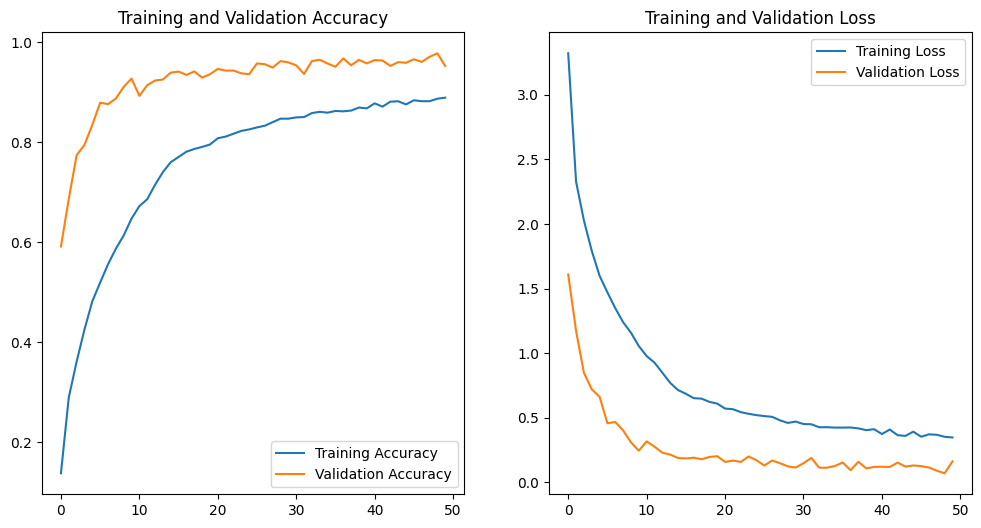

In [6]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(baseline_history.history['accuracy'], label='Training Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(baseline_history.history['loss'], label='Training Loss')
plt.plot(baseline_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [7]:
# Retrieve the training accuracy
final_train_accuracy = baseline_history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")

# Retrieve the validation accuracy
final_val_accuracy = baseline_history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")


Final Training Accuracy: 88.91%
Final Validation Accuracy: 95.22%


### ResNet with  pre-trained weights

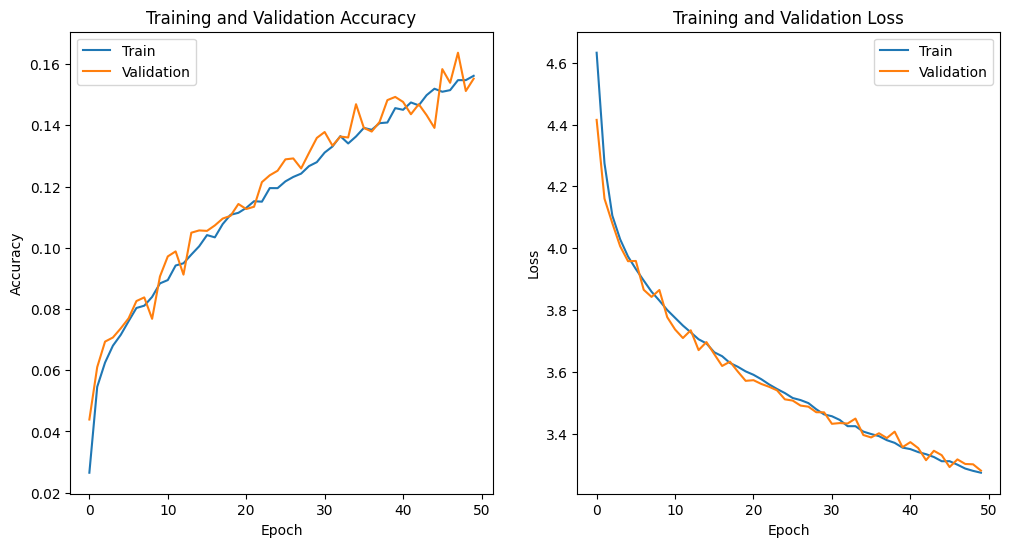

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ResNet_history.history['accuracy'], label='Train')
plt.plot(ResNet_history.history['val_accuracy'], label='Validation')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(ResNet_history.history['loss'], label='Train')
plt.plot(ResNet_history.history['val_loss'], label='Validation')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [19]:
# Retrieve the training accuracy
final_train_accuracy = ResNet_history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")

# Retrieve the validation accuracy
final_val_accuracy = ResNet_history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")

Final Training Accuracy: 15.61%
Final Validation Accuracy: 15.52%


## Testing 

### Baseline CNN Model

In [8]:
# Evaluate on the test set
test_generator.reset()  # Reset the generator to avoid shuffling issues
test_loss, test_accuracy = baseline_model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print(f"Test Loss: {test_loss* 100:.2f}%")
print(f"Test Accuracy: {test_accuracy* 100:.2f}%")

709/709 [==============================] - 6s 8ms/step - loss: 0.1632 - accuracy: 0.9644
Test Loss: 16.32%
Test Accuracy: 96.44%
